In [1]:
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
from scipy.signal import savgol_filter 
from scipy.optimize import root_scalar

# Maier Saupe Model 

The free energy is given by: 
$$ 
f(t,\overline{\mu}, Q_{\mu\nu}) = + \frac{1}{2}\sum_{\mu,\nu}Q^2_{\mu\nu} - t\ln \left[ 3 + e^{-\frac{\overline{\mu}}{t} - \frac{1}{2t}\sum_\mu Q_{\mu\mu}}\sum_{\mu}e^{\frac{3}{2t}Q_{\mu\mu}} \right]
$$
where $\mu=x,y,z$. Here we perform the chenge of variables $S \equiv Q_{zz}$ and $\eta \equiv Q_{yy} - Q_{xx}$

#### If $S\neq 0$ and $\eta = 0$

/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_44449/2646851280.py:16: RuntimeWarning: overflow encountered in scalar power
  denominator = 4*t*(2+exp1+3*exp2)**2
/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_44449/2646851280.py:17: RuntimeWarning: overflow encountered in scalar power
  denominator2= 2*t*(2+exp1+3*exp2)**2


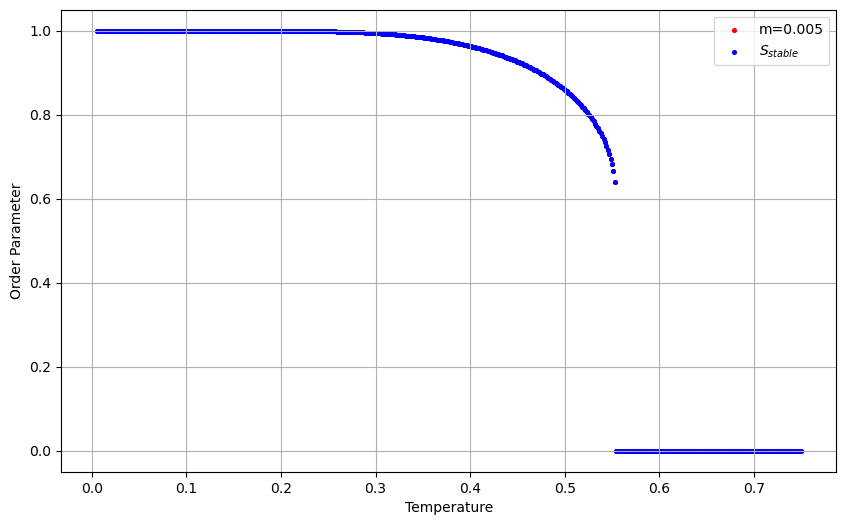

In [2]:
def first_eqs(t,m,S):     
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((1/4)*(S+4*m)/t) 

    nom = 1 - exp1
    denom = 2 + exp1 + 3*exp2

    return nom/denom + S 

def hessian(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t))
    exp3=np.exp((3*S+m)/t)

    # Define the denominator
    denominator = 4*t*(2+exp1+3*exp2)**2
    denominator2= 2*t*(2+exp1+3*exp2)**2

    # Define the elements of the Hessian matrix 
    H11 = 1 - 3*(3+3*exp1+5*exp2+exp3)/denominator
    H12 = (9 - 3*exp2*(-4 + exp1))/denominator
    H13 = (9*exp1+3*exp2+6*exp3)/denominator
    H33 =  1 - (9*exp1 + 6*exp3 + 3*exp2)/denominator2


    # Construct the Hessian matrix using numpy
    hessian_matrix = np.array([[H11, H12, H13],
                            [H12, H11, H13],
                        [H13, H13, H33]])
    
    return hessian_matrix


eigenvalues=[] 
def stability_check(t, m, S, tol=1e-8): 
    eigen_values = eigvals(hessian(t, m, S))
    eigenvalues.append(eigen_values)

    return all(ev > -tol for ev in eigen_values)

m=0.005

T_vals = np.linspace(0.005, 0.75, 500)
S_vals = []

S_vals = []
for T in T_vals:
    # Solve for S
    sol = root_scalar(lambda S: first_eqs(T, m, S), method='newton', x0= S_vals[-1] if S_vals else 1.0)

    if sol.converged:
        S_vals.append(sol.root)
    else:
        # Try fallback
        sol = root_scalar(lambda S: first_eqs(T, m, S), method='bisect', bracket=[-1.0, 2.0])
        if sol.converged:
            S_vals.append(sol.root)
        else:
            S_vals.append(np.nan)  # Mark failure

S_stable=[]
T_stable=[]

for i in range(len(T_vals)): 
    if stability_check(T_vals[i],m ,S_vals[i]):
        S_stable.append(S_vals[i]) 
        T_stable.append(T_vals[i]) 


# Plot
fig=plt.figure(figsize=(10, 6))

plt.scatter(T_vals, S_vals, label=f'm={m}', color='red',s=7)
plt.scatter(T_stable, S_stable, label=r'$S_{stable}$', color='blue',s=7) 

plt.xlabel('Temperature')
plt.ylabel('Order Parameter')
plt.legend()
plt.grid(True) 
plt.show() 

## Phase Diagram

In [69]:
####### Generating Experiments Files
def first_eqs(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t)) 

    nom = 1 - exp1
    denom = 2 + exp1 + 3*exp2

    return nom/denom + S 

def hessian(t,m,S): 
    exp1=np.exp((9/4)*S/t)
    exp2=np.exp((3*S+4*m)/(4*t))
    exp3=np.exp((3*S+m)/t)

    # Define the denominator
    denominator = 4*t*(2+exp1+3*exp2)**2
    denominator2= 2*t*(2+exp1+3*exp2)**2

    # Define the elements of the Hessian matrix 
    H11 = 1 - 3*(3+3*exp1+5*exp2+exp3)/denominator
    H12 = (9 - 3*exp2*(-4 + exp1))/denominator
    H13 = (9*exp1+3*exp2+6*exp3)/denominator
    H33 =  1 - (9*exp1 + 6*exp3 + 3*exp2)/denominator2

    # Construct the Hessian matrix using numpy
    hessian_matrix = np.array([[H11, H12, H13],
                            [H12, H11, H13],
                        [H13, H13, H33]])
    
    return hessian_matrix

def stability_check(t, m, S, tol=1e-9): 
    
    H = hessian(t, m, S)
    H = (H + H.T) / 2  # Enforce symmetry just in case

    eigen_values = np.real_if_close(eigvals(H))

    return all(ev > tol for ev in eigen_values)

eigenvalues=[]
m_sample = np.linspace(0.01, 0.75, 500)  
n = len(m_sample)
stability_map = np.full((n, n), 0, dtype=float)

for line, m in enumerate(m_sample):
    T_vals = np.linspace(0.01, 0.75, 500)
    S_vals = []

    for t in T_vals:
        # Solve for S
        sol = root_scalar(lambda S: first_eqs(t, m, S), method='newton', x0= S_vals[-1] if S_vals else 1.0)

        if sol.converged:
            S_vals.append(sol.root)
        else:
            # Try fallback
            sol = root_scalar(lambda S: first_eqs(t, m, S), method='bisect', bracket=[-1.0, 2.0])
            if sol.converged:
                S_vals.append(sol.root)
            else:
                S_vals.append(np.nan)  # Mark failure

    for column, (t, S) in enumerate(zip(T_vals, S_vals)):
        if stability_check(t, m, S):
            stability_map[line, column] = S  # Only assign if stable

    # Saving stable points for each m
    stable_indices = np.where(~np.isnan(stability_map[line]))
    S_stable = stability_map[line][stable_indices]
    T_stable = T_vals[stable_indices]

    np.savetxt(f'Data/Uniaxial_{line+1}.csv', np.column_stack((S_stable, T_stable)), 
               delimiter=' ', fmt='%f', header=f'Constant m: {m}\nS_vals T_vals')

np.savetxt('Stability_map.txt', stability_map, delimiter=' ', fmt='%f')


#### Stability Map Plot

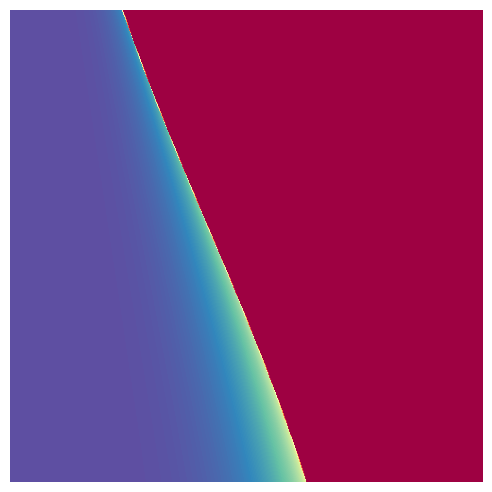

In [70]:
data = np.loadtxt("Stability_map.txt")
data = np.ma.masked_invalid(data) 

cmap='Spectral'
cm = 1/2.54
plt.figure(figsize=(12*cm, 12*cm))  # Adjust for output size in cm
plt.imshow(data, origin='lower', cmap=cmap, extent=[0, 500, 0, 500])
plt.axis('off')  
plt.tight_layout(pad=0)
plt.savefig("heatmap.png", dpi=600, bbox_inches='tight', pad_inches=0, transparent=True)

#### Import colormap
cmap = plt.get_cmap(cmap)
n = 100  # Number of color sample
with open("Spectral_colormap.tex", "w") as f:
    f.write("\\pgfplotsset{\n    colormap={Spectral}{%\n")
    for i in range(n):
        r, g, b, _ = cmap(i / (n - 1))
        f.write(f"        rgb({i})=({r:.4f},{g:.4f},{b:.4f})")
        if i != n - 1:
            f.write(",\n")
        else:
            f.write("\n")
    f.write("    }\n}\n")


#### Transition Line

In [84]:
####### Reading Files 
def file_reader(index): 
    file_path = f'Data/Uniaxial_{index}.csv' 
    data = np.loadtxt(file_path, delimiter=' ', skiprows=2) 
    
    # Extract columns
    S_vals = data[:, 0]
    T_vals = data[:, 1]

    return S_vals, T_vals 

def free_energy(t,S,m): 
    exp1=np.exp(-(3*S+4*m)/(4*t))
    exp2=np.exp((9/4)*S/t) 

    return (3/4)*S**2 - t*np.log(3+exp1*(2+exp2))    


T_c= [] #Critical Temperature Transition
stb1= [] #Stability Curve 1
stb2= [] #Stability Curve 2 
first=[]
for idx, m in enumerate(m_sample, 1): 
    # Read data for current sample
    S_vals, T_vals = file_reader(idx)
    delta_e = []

    # Compute delta free energy
    for T, S in zip(T_vals, S_vals):     
        delta = free_energy(T, S, m) + T * np.log(3 + 3 * np.exp(-m / T))
        delta_e.append(delta)

    # Find transition temperature (where delta crosses zero)
    transition_index = None
    for j in range(len(delta_e) - 1):
        if delta_e[j] < 0 and delta_e[j + 1] >= 0:
            transition_index = j + 1
            break

    if transition_index is not None:
        transition_temperature = T_vals[transition_index]
        T_c.append(transition_temperature)
    else:
        # Handle the case where no transition was found
        T_c.append(None)
        continue  # Skip stability checks if transition not found

    # First stability check with S = 0 (from high to low temperature)
    for T in reversed(T_vals):
        S = 0
        if not stability_check(T, m, S): 
            stb1.append(T)
            break
    
    if idx==1: 
        first=[S_vals[transition_index]]
    """
    # Second stability check with S at transition (from low to high temperature)
    S_at_transition = S_vals[transition_index]
    for T in T_vals:
        if not stability_check(T, m, S_at_transition): 
            stb2.append(T)
            break
    """ 
        

In [85]:
first

[0.69644]

In [86]:
def stability_check2(t, m, S, tol=1e-9): 
    
    H = hessian(t, m, S)
    H = (H + H.T) / 2  # Enforce symmetry just in case

    eigen_values = np.real_if_close(eigvals(H))

    # Warn if T is very small
    if t < 0.05:
        print(f"[LOW T WARNING] T={t:.5f}, m={m:.3f}, S={S:.3f}")
        print("  Hessian =", H)
        print("  Eigenvalues =", eigen_values)

    return all(ev > tol for ev in eigen_values)

i=1
print(m_sample[i])
for T in T_vals:
    S = first[0]
    print(stability_check2(T, m_sample[i], S))


0.011482965931863728
[LOW T WARNING] T=0.01000, m=0.011, S=0.696
  Hessian = [[ 1.00000000e+00 -1.01100381e-43  2.02200761e-43]
 [-1.01100381e-43  1.00000000e+00  2.02200761e-43]
 [ 2.02200761e-43  2.02200761e-43  1.00000000e+00]]
  Eigenvalues = [1. 1. 1.]
True
[LOW T WARNING] T=0.01148, m=0.011, S=0.696
  Hessian = [[ 1.00000000e+00 -5.49013076e-38  1.09802615e-37]
 [-5.49013076e-38  1.00000000e+00  1.09802615e-37]
 [ 1.09802615e-37  1.09802615e-37  1.00000000e+00]]
  Eigenvalues = [1. 1. 1.]
True
[LOW T WARNING] T=0.01297, m=0.011, S=0.696
  Hessian = [[ 1.00000000e+00 -1.43260019e-33  2.86520037e-33]
 [-1.43260019e-33  1.00000000e+00  2.86520037e-33]
 [ 2.86520037e-33  2.86520037e-33  1.00000000e+00]]
  Eigenvalues = [1. 1. 1.]
True
[LOW T WARNING] T=0.01445, m=0.011, S=0.696
  Hessian = [[ 1.0000000e+00 -4.5809737e-30  9.1619474e-30]
 [-4.5809737e-30  1.0000000e+00  9.1619474e-30]
 [ 9.1619474e-30  9.1619474e-30  1.0000000e+00]]
  Eigenvalues = [1. 1. 1.]
True
[LOW T WARNING] T=0.

#### Smothing the curve 

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_44449/473745104.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')
/var/folders/1q/ck574qds4v36l1t2j4jftvq80000gn/T/ipykernel_44449/473745104.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


ValueError: x and y must be the same size

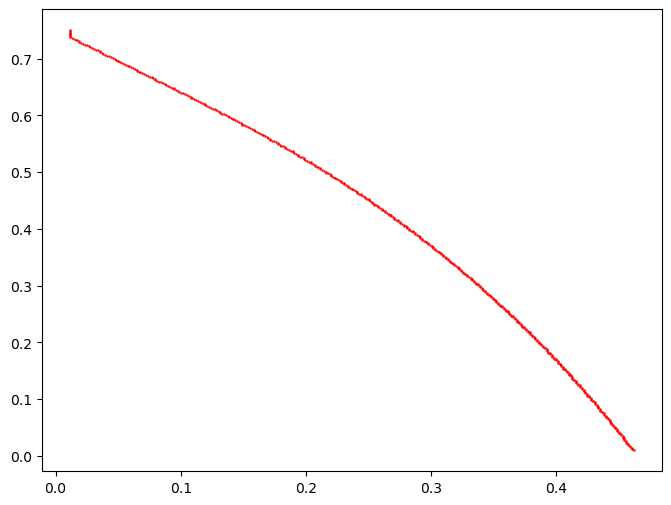

In [6]:
Tc_hat = savgol_filter(T_c, 51, 3) # window size 51, polynomial order 3  
#stb1_hat = savgol_filter(stb1, 51, 3)
#stb2_hat = savgol_filter(stb2, 51, 3) 

fig3=plt.figure(figsize=(8, 6))

plt.scatter(T_c, m_sample, label='Tc',color='red',s=0.5) 
plt.scatter(stb1, m_sample, label='stb1',color='blue',s=0.5) 
plt.scatter(stb2, m_sample, label='stb2',color='green',s=0.5) 
plt.plot(Tc_hat, m_sample, '-.', label='Adjusted curve')  

plt.ylabel('$\mu$')
plt.xlabel('T')
plt.legend()
plt.grid(True) 
plt.show() 

data2 = np.column_stack((Tc_hat, m_sample))
stability_data1= np.column_stack((stb1, m_sample))
stability_data2= np.column_stack((stb2, m_sample))

np.savetxt('DMS_data', data2 , delimiter=' ', fmt='%f')  
np.savetxt('DMS_stability1', stability_data1 , delimiter=' ', fmt='%f')  
np.savetxt('DMS_stability2', stability_data2 , delimiter=' ', fmt='%f')  

### Energy Analysis

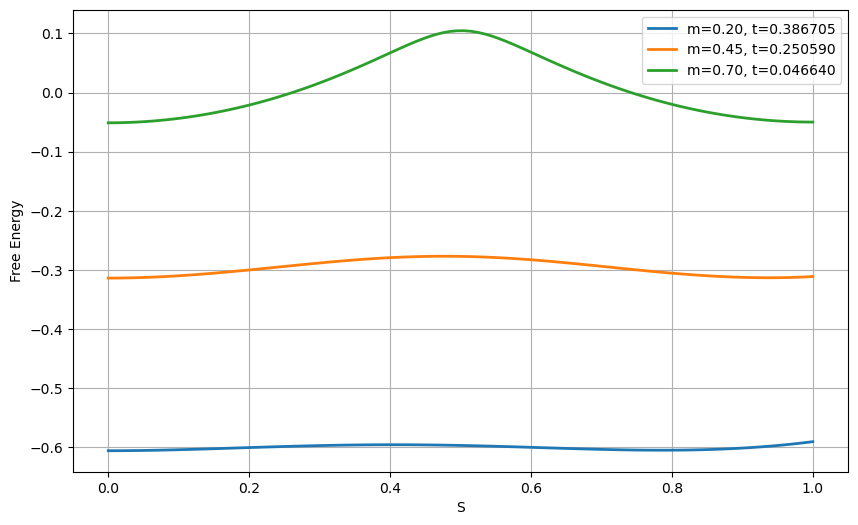

In [209]:
def free_energy(t,S,m): 
    exp1=np.exp(-(3*S+4*m)/(4*t))
    exp2=np.exp((9/4)*S/t) 

    return (3/4)*S**2 - t*np.log(3+exp1*(2+exp2))    

def find_nearest(array, value):     
    array = np.asarray(array)   
    idx = (np.abs(array - value)).argmin()    
    return idx

i=0
m_sample = np.linspace(0.01, 0.75, 500)  
m_vals= [0.2, 0.45, 0.7]
t_sample= [Tc_hat[find_nearest(m_sample,m_vals[0])], Tc_hat[find_nearest(m_sample,m_vals[1])], Tc_hat[find_nearest(m_sample,m_vals[2])]] 
S_sample= np.linspace(0.0, 1.0, 100) 

fig=plt.figure(figsize=(10, 6))

for m,t in zip(m_vals,t_sample): 
    energy = []
    i+=1
     
    for s in S_sample:
        energy.append(free_energy(t,s,m))

    #Save the data     
    data = np.column_stack((S_sample, energy))
    np.savetxt(f'DMS_Energy_{i}', data , delimiter=' ', fmt='%f') 
    
    # Plot the curves
    plt.plot(S_sample, energy, linewidth=2, label=f'm={m:.2f}, t={t:.6f}')

# Plot settings
plt.xlabel('S')
plt.ylabel('Free Energy')
plt.grid(True)
plt.legend()
plt.show()